# Wong and Wang Simplified 2-Variable Model

The dynamics of this model can be described by:  
$$
\begin{align}
  \frac{dS_i}{dt} &= -\frac{S_i}{\tau_S} + (1-S_i)\gamma H(x_i)\\
  H(x_i) &= \frac{ax_i - b}{1 - \exp[-d(ax_i - b)]}\\
  x_i &= J^N_{ii}S_i - J^N_{ij}S_j + I_o + I_i + I_{\text{noise},i}, \quad i,j \in \{1, 2\}, \quad i \neq j\\
  I_i &= J^A_{\text{ext}} \mu_0 \left( 1 \pm \frac{c'}{100\%} \right)\\
  \tau_{\text{AMPA}} \frac{dI_{\text{noise},i}}{dt} &= -I_{\text{noise},i}(t) + \eta_i(t) \sqrt{\tau_{\text{AMPA}} \sigma^2_{\text{noise}}}
\end{align}
$$
Various parameter values are given.

To get $J_{ij}, J_{ii}$ in terms of $w_+, w_-$ and $w_{\text{else}}$ from the original model, we can try write
$$
\begin{aligned}
J_{ii} = 0.2609 nA &= w_+ K\\
&= 1.7 K\\
J_{ij} = 0.0497 nA &= w_- K + w_{\text{else}} G w_{\text{else}} \\
 &= [1-f(w_- -1)/(1-f)] K + w_{\text{else}} G w_{\text{else}}\\
\end{aligned}
$$
This gives us $K = 0.15347..nA$ and hence $G = -0.084812.. nA$ when $f=0.15$.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

## Wang Book Code:

In [2]:
# download
# !curl -o wong2006.py https://raw.githubusercontent.com/xjwanglab/book/master/wong2006/wong2006.py
# !sed -i 's/xrange/range/g' wong2006.py

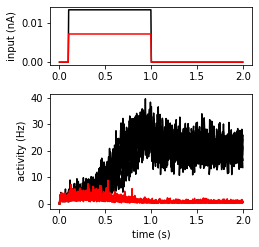

In [3]:
from wong2006 import modelparams, Model

wong2006model = Model(modelparams)
wong2006model.run(coh=30, n_trial=10)

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.2, 0.7, 0.7, 0.2])
plt.plot(wong2006model.t, wong2006model.I1, 'black')
plt.plot(wong2006model.t, wong2006model.I2, 'red')
plt.ylabel('input (nA)')

ax = fig.add_axes([0.2, 0.2, 0.7, 0.4])
plt.plot(wong2006model.t, wong2006model.r1,'black')
plt.plot(wong2006model.t, wong2006model.r2,'red')
plt.xlabel('time (s)')
plt.ylabel('activity (Hz)')
plt.show()

## OOP Formulation:

In [4]:
def check_variable(var, varname=None):
        if np.any(np.isnan(var)):
            num_nans = np.isnan(var).astype(int).sum()
            print(f"Variable {varname} contains {num_nans} NaN")
        if np.any(np.isinf(var)):
            num_infs = np.isinf(var).astype(int).sum()
            print(f"Variable {varname} contains {num_infs} infinities")


def check_output(func):
    funcname = func.__name__
    def new_func(*args, **kwargs):
        retval = func(*args, **kwargs)
        if np.any(np.isnan(retval)):
            num_nans = np.isnan(retval).astype(int).sum()
            print("Output of " + funcname + f" contains {num_nans} NaNs")
        if np.any(np.isinf(retval)):
            num_infs = np.isinf(retval).astype(int).sum()
            print("Output of " + funcname + f" contains {num_infs} infinities")
        return retval
    return new_func


class WongWangSimulation():
    def __init__(
        self,
        tau_S = 0.1,  # seconds 100,  # mseconds
        gamma = 0.641,  # AU

        a = 270.,  # (VnC)^-1
        b = 108.,  # Hz
        d = 0.154,  # seconds 154,  # mseconds

        J_N11 = 0.2609,  # nA  i.e. 10^-9 A
        J_N12 = 0.0497,  # nA
        J_N21 = 0.0497,  # nA
        J_N22 = 0.2609,  # nA
        I_0 = 0.3255,  # nA

        J_extA = 5.2e-4,  # nA.Hz^-1
        mu_0 = 20.,  # Hz, taken from wong2006.py code. Paper says 30 Hz

        tau_AMPA = 0.002, # seconds  2,  # mseconds
        sigma_noise = 0.02,  # nA
    ):
        self.tau_S = tau_S
        self.gamma = gamma
        self.a = a
        self.b = b
        self.d = d
        self.J_N11 = J_N11
        self.J_N12 = J_N12
        self.J_N21 = J_N21
        self.J_N22 = J_N22
        self.I_0 = I_0
        self.J_extA = J_extA
        self.mu_0 = mu_0
        self.tau_AMPA = tau_AMPA
        self.sigma_noise = sigma_noise
    
    @check_output
    def get_xi(self, Si, Sj, I_noisei=0, I_i=0, i=1, I_0=None):
        """Only input I_0 if it is not included in I_noisei"""
        if I_0 is None:
            I_0 = self.I_0
        if i == 1:
            J_Nii = self.J_N11
            J_Nij = self.J_N12
        elif i == 2:
            J_Nii = self.J_N22
            J_Nij = self.J_N21
        else:
            raise Exception('i must be 1 or 2')
        return J_Nii*Si - J_Nij*Sj + I_0 + I_i + I_noisei
    
    @check_output
    def get_H(self, xi):
        w = self.a*xi - self.b
        return w / (1 - np.exp(-self.d*w))
    
    @check_output
    def get_dH_dxi(self, xi):
        w = self.a * xi - self.b
        # H(x) = f(w)
        df_dw = (1-w*self.d*np.exp(-self.d * w)/(1-np.exp(-self.d * w)))/(1-np.exp(-self.d * w))
        return self.a * df_dw
    
    @check_output
    def get_dSi_dt(self, Si, H_xi=None, xi=None):
        assert H_xi is not None or xi is not None,\
            "Please input rate or rate prefactor"
        if H_xi is None:
            H_xi = self.get_H(xi)
        return -Si / self.tau_S + (1-Si)*self.gamma*H_xi
    
    @check_output
    def get_expected_d2Si_dt2(self, Si, Sj, I_noisei=0, I_noisej=0, I_i=0, I_j=0, I_0=None, i=1):
        if i == 1:
            J_Nii = self.J_N11
            J_Nij = self.J_N12
            j = 2
        elif i == 2:
            J_Nii = self.J_N22
            J_Nij = self.J_N21
            j = 1
        else:
            raise Exception('i must be 1 or 2')
        xi = self.get_xi(Si, Sj, I_noisei=I_noisei, I_i=I_i, i=i, I_0=I_0)
        xj = self.get_xi(Sj, Si, I_noisei=I_noisej, I_i=I_j, i=j, I_0=I_0)
        H_xi = self.get_H(xi)
        H_xj = self.get_H(xj)
        
        dSi_dt = self.get_dSi_dt(Si, H_xi)
        dSj_dt = self.get_dSi_dt(Sj, H_xj)
        dH_dxi = self.get_dH_dxi(xi)
        
        dSi_term = (-1/self.tau_S - H_xi*self.gamma + (1-Si)*self.gamma*dH_dxi*J_Nii) * dSi_dt
        dSj_term = -(1-Si)*self.gamma*dH_dxi*J_Nij*dSj_dt
        return dSi_term + dSj_term
    
#     @check_output
#     def get_dInoisei_dt(self, Inoisei, etai):
#         print("Use get_dt_times_dInoisei_dt instead!")
#         return (-Inoisei + etai * np.sqrt(self.tau_AMPA * self.sigma_noise**2)) / self.tau_AMPA
    
    @check_output
    def get_dt_times_dInoisei_dt(self, Inoisei, Inoise_mean=0, etai=None, dt=1):
        """Inoise_mean can be used as I0, but then remove it from get_xi"""
        if etai is None:
            etai = np.random.randn()
        drift = (Inoise_mean-Inoisei)*dt/self.tau_AMPA
        variability = etai*np.sqrt(dt/self.tau_AMPA)*self.sigma_noise
        return drift + variability
    
    @check_output
    def get_Ii(self, coherence, i=1):
        assert i in [i, 2],\
            "i must be 1 or 2"
        if i == 1:
            return self.J_extA * self.mu_0 * (1 + coherence / 100)
        else:
            return self.J_extA * self.mu_0 * (1 - coherence / 100)
    
    def run_simulation(
        self,
        runtime=2,  # seconds
        dt=0.05/1000,  # seconds
        save_every=1,  # n timesteps to save
        stimulus_start=0.1,  # seconds
        stimulus_end=0.2,  # seconds
        coherence=0,  # %
        threshold_S=None,  # \in [0, 1], symmetric
        threshold_H=None,
        S1_start=0.1,
        S2_start=0.1,
        verbose=False,
        n_runs=1
    ):
        # initialise variables
        timesteps = np.arange(0.0, runtime, dt)
        num_values = timesteps.shape[0]
        S1 = np.zeros(shape=(num_values, n_runs))
        S1[0, :] = S1_start
        S2 = np.zeros(shape=(num_values, n_runs))
        S2[0, :] = S2_start
        Inoise1 = np.zeros(shape=(num_values, n_runs))
        Inoise2 = np.zeros(shape=(num_values, n_runs))
        whitenoise1 = np.random.randn(num_values-1, n_runs)
        whitenoise2 = np.random.randn(num_values-1, n_runs)
        
        save_values = False
        if isinstance(save_every, int):
            save_values = save_every > 0
        if save_values:
            num_save_values = int(np.ceil(num_values/save_every))
            I1 = np.zeros(shape=(num_save_values, n_runs))
            I2 = np.zeros(shape=(num_save_values, n_runs))
            X1 = np.zeros(shape=(num_save_values, n_runs))
            X2 = np.zeros(shape=(num_save_values, n_runs))
            H1 = np.zeros(shape=(num_save_values, n_runs))
            H2 = np.zeros(shape=(num_save_values, n_runs))
            dS1dt = np.zeros(shape=(num_save_values, n_runs))
            dS2dt = np.zeros(shape=(num_save_values, n_runs))
#             dInoise1dt = np.zeros(num_save_values)
#             dInoise2dt = np.zeros(num_save_values)
            dInoise1 = np.zeros(shape=(num_save_values, n_runs))
            dInoise2 = np.zeros(shape=(num_save_values, n_runs))
            saveval = 0
        
        # run sim
        stimulus_running = False
        for i, t in enumerate(timesteps[1:], start=1):
            s1 = S1[i-1, :]
            s2 = S2[i-1, :]
            inoise1 = Inoise1[i-1, :]
            inoise2 = Inoise2[i-1, :]
            i1 = 0
            i2 = 0
            if t >= stimulus_start and t < stimulus_end:
                if not stimulus_running and verbose: print(f'Starting stimulus at {t}')
                stimulus_running = True
                i1 = self.get_Ii(coherence=coherence, i=1)
                i2 = self.get_Ii(coherence=coherence, i=2)
#                 i1 = self.J_extA * self.mu_0 * (1 + coherence / 100)
#                 i2 = self.J_extA * self.mu_0 * (1 - coherence / 100)

            elif stimulus_running:
                stimulus_running = False
                if verbose: print(f'Ended stimulus at {t}')
            x1 = self.get_xi(
                Si=s1, Sj=s2,
                I_noisei=inoise1,
                I_i=i1, i=1,
                I_0=0
            )
            ## NOPE ##
#             x1 = self.get_xi(
#                 Si=s1, Sj=s2, I_noisei=inoise1, I_i=i1, i=1,
#                 I_0=self.I_0*dt/self.tau_AMPA
#             )
            h_x1 = self.get_H(x1)
            x2 = self.get_xi(
                Si=s2, Sj=s1,
                I_noisei=inoise2,
                I_i=i2, i=2,
                I_0=0
            )
            ## NOPE ##
#             x2 = self.get_xi(
#                 Si=s2, Sj=s1, I_noisei=inoise2, I_i=i2, i=2,
#                 I_0=self.I_0*dt/self.tau_AMPA
#             )
            h_x2 = self.get_H(x2)
            
            ds1dt = self.get_dSi_dt(Si=s1, H_xi=h_x1)
            ds2dt = self.get_dSi_dt(Si=s2, H_xi=h_x2)
            s1_new = s1 + ds1dt * dt
            s2_new = s2 + ds2dt * dt
            
#             dinoise1dt = self.get_dInoisei_dt(Inoisei=inoise1, etai=whitenoise1[i-1])
            dinoise1 = self.get_dt_times_dInoisei_dt(
                Inoisei=inoise1,
                Inoise_mean=self.I_0,
                etai=whitenoise1[i-1],
                dt=dt
            )
#             dinoise2dt = self.get_dInoisei_dt(Inoisei=inoise2, etai=whitenoise2[i-1])
            dinoise2 = self.get_dt_times_dInoisei_dt(
                Inoisei=inoise2,
                Inoise_mean=self.I_0,
                etai=whitenoise2[i-1],
                dt=dt
            )
            inoise1_new = inoise1 + dinoise1
            inoise2_new = inoise2 + dinoise2
            
            S1[i] = s1_new
            S2[i] = s2_new
            Inoise1[i] = inoise1_new
            Inoise2[i] = inoise2_new
            if bool(save_every):
                if (i-1) % save_every == 0:
                    I1[saveval] = i1
                    I2[saveval] = i2
                    X1[saveval] = x1
                    X2[saveval] = x2
                    H1[saveval] = h_x1
                    H2[saveval] = h_x2
                    dS1dt[saveval] = ds1dt
                    dS2dt[saveval] = ds2dt
#                     dInoise1dt[saveval] = dinoise1dt
#                     dInoise2dt[saveval] = dinoise2dt
                    dInoise1[saveval] = dinoise1
                    dInoise2[saveval] = dinoise2
                    saveval += 1
            
            if threshold_S is not None:
                if s1_new >= threshold_S or s2_new >= threshold_S:
                    break
            if threshold_H is not None:
                if h_x1 >= threshold_H or h_x2 >= threshold_H:
                    break
        if save_values:
            return_dict = dict(
                S1 = S1,
                S2 = S2,
                Inoise1 = Inoise1,
                Inoise2 = Inoise2,
                I1 = I1,
                I2 = I2,
                X1 = X1,
                X2 = X2,
                H1 = H1,
                H2 = H2,
                dS1dt = dS1dt,
                dS2dt = dS2dt,
                dInoise1=dInoise1,
                dInoise2=dInoise2,
                eta1 = whitenoise1,
                eta2 = whitenoise2,
                timesteps = timesteps
            )
        else:
            return_dict = dict(
                S1 = S1,
                S2 = S2,
                Inoise1 = Inoise1,
                Inoise2 = Inoise2,
                eta1 = whitenoise1,
                eta2 = whitenoise2,
                timesteps = timesteps
            )
        return return_dict

model = WongWangSimulation()

In [5]:
params = dict(
    runtime=2,  # seconds
    dt=0.5/1000,  # seconds
    save_every=10,
    stimulus_start=0.1,  # seconds
    stimulus_end=1,  # seconds
    coherence=20,  # %
    threshold_S=None,  # \in [0, 1], symmetric
    threshold_H=None,
    S1_start=0.1,  # 0.235
    S2_start=0.1,
    n_runs=2
)

values = model.run_simulation(
    **params,
    verbose=True
)

Starting stimulus at 0.1
Ended stimulus at 1.0


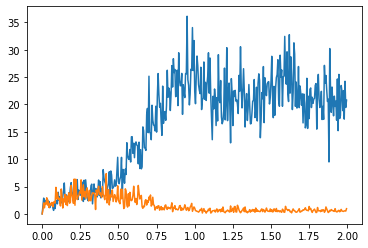

In [13]:
plt.plot(values['timesteps'][::params['save_every']], values['H1'][:,0]);
plt.plot(values['timesteps'][::params['save_every']], values['H2'][:,0]);

In [ ]:
plt.plot(wong2006model.r1[:,0]);
plt.plot(wong2006model.r2[:,0]);

## Some Plots:

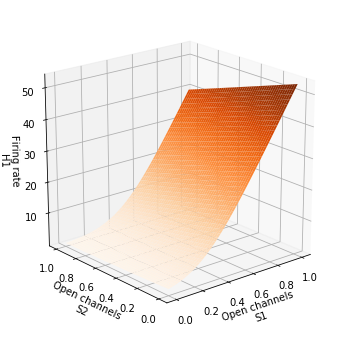

In [14]:
num_points = 1000

S1 = np.linspace(0, 1, num_points)
S2 = np.linspace(0, 1, num_points)
S1_, S2_ = np.meshgrid(S1, S2)

H1_ = model.get_H(model.get_xi(
    S1_, S2_,
    I_i=model.J_extA*model.mu_0
))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S1_, S2_, H1_, cmap=cm.Oranges)
ax.set_zlabel('Firing rate\nH1')
ax.set_xlabel('Open channels\nS1')
ax.set_ylabel('Open channels\nS2')
ax.view_init(20, 230)
plt.show()

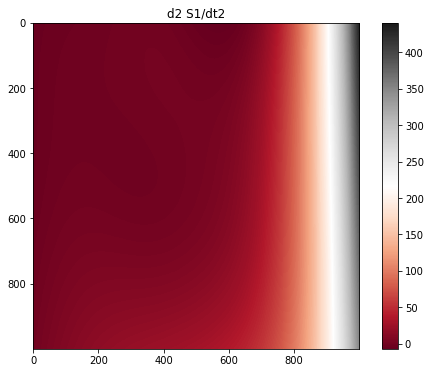

In [73]:
dS1dt_ = model.get_expected_d2Si_dt2(
    Si=S1_, Sj=S2_, I_i=model.J_extA*model.mu_0, I_j=model.J_extA*model.mu_0
)
plt.figure(figsize=(8,6))
cmap=cm.RdGy
cmap.set_bad(color='green')
plt.imshow(dS1dt_, cmap=cmap)
plt.colorbar()
plt.title('d2 S1/dt2')
plt.show()

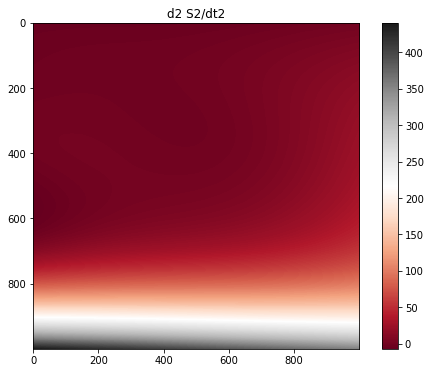

In [74]:
dS2dt_ = model.get_expected_d2Si_dt2(
    Si=S2_, Sj=S1_, i=2,
    I_i=model.J_extA*model.mu_0, I_j=model.J_extA*model.mu_0
)

plt.figure(figsize=(8,6))
cmap=cm.RdGy
cmap.set_bad(color='green')
plt.imshow(dS2dt_, cmap=cmap)
plt.colorbar()
plt.title('d2 S2/dt2')
plt.show()

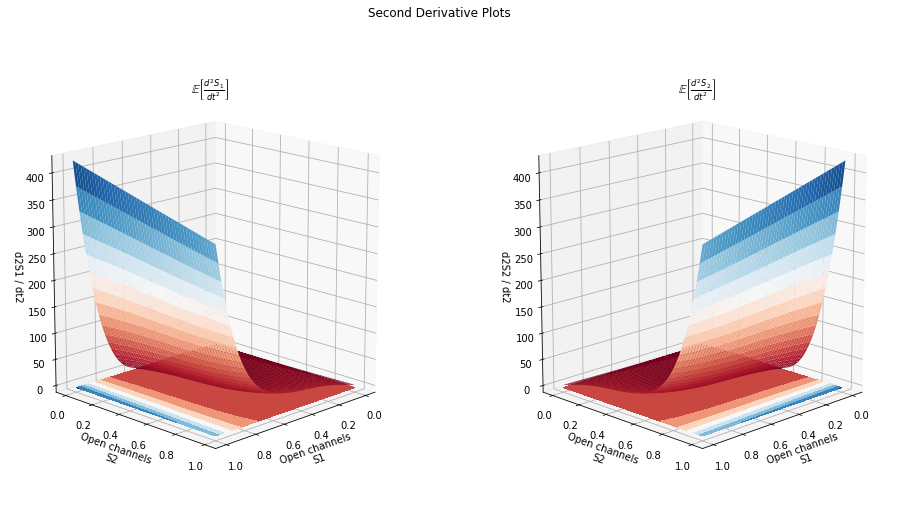

In [17]:
import warnings
warnings.filterwarnings('ignore')

d2S1dt2_ = model.get_expected_d2Si_dt2(
    Si=S1_, Sj=S2_,
#     I_0=0,
#     I_i=model.J_extA*model.mu_0, I_j=model.J_extA*model.mu_0
)
d2S2dt2_ = model.get_expected_d2Si_dt2(
    Si=S2_, Sj=S1_, i=2,
#     I_0=0,
#     I_i=model.J_extA*model.mu_0, I_j=model.J_extA*model.mu_0
)

cmap = cm.RdBu
cmap.set_bad(color='orange')

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(121, projection='3d')
offset = d2S1dt2_[~np.isnan(d2S1dt2_) & ~np.isinf(d2S1dt2_)].min()
maxval = d2S1dt2_[~np.isnan(d2S1dt2_) & ~np.isinf(d2S1dt2_)].max()
ax.contourf(S1_, S2_, d2S1dt2_, offset=offset, cmap=cmap)
# ax.scatter([0.1, 0.15, 0.6], [0.6, 0.15, 0.1], [0,0,0], s=4, color='black')
ax.plot_surface(S1_, S2_, d2S1dt2_, cmap=cmap, vmin=offset, vmax=maxval)
ax.set_zlabel('d2S1 / dt2')
ax.set_xlabel('Open channels\nS1')
ax.set_ylabel('Open channels\nS2')
ax.set_title(r"$\mathbb{E}\left[\frac{d^2S_1}{dt^2}\right]$")
ax.view_init(15, 45)

ax = fig.add_subplot(122, projection='3d')
offset = d2S2dt2_[~np.isnan(d2S2dt2_) & ~np.isinf(d2S2dt2_)].min()
maxval = d2S1dt2_[~np.isnan(d2S2dt2_) & ~np.isinf(d2S2dt2_)].max()
ax.contourf(S1_, S2_, d2S2dt2_, offset=offset, cmap=cmap)
ax.plot_surface(S1_, S2_, d2S2dt2_, cmap=cmap, vmin=offset, vmax=maxval)
ax.set_zlabel('d2S2 / dt2')
ax.set_xlabel('Open channels\nS1')
ax.set_ylabel('Open channels\nS2')
ax.set_title(r"$\mathbb{E}\left[\frac{d^2S_2}{dt^2}\right]$")
ax.view_init(15, 45)

fig.suptitle("Second Derivative Plots")
plt.savefig('Second Derivative Plots')
plt.show()

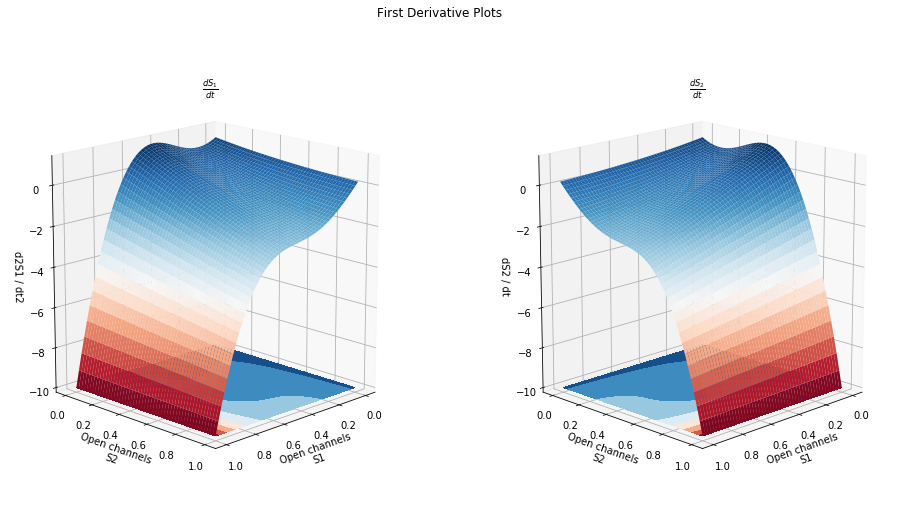

In [18]:
X1_ = model.get_xi(
    Si=S1_, Sj=S2_,
    I_i=model.J_extA*model.mu_0
)
X2_ = model.get_xi(
    Si=S2_, Sj=S1_,
    I_i=model.J_extA*model.mu_0,
    i=2
)
dS1dt_ = model.get_dSi_dt(
    Si=S1_, xi=X1_
)
dS2dt_ = model.get_dSi_dt(
    Si=S2_, xi=X2_
)

cmap = cm.RdBu
cmap.set_bad(color='orange')

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(121, projection='3d')
offset = dS1dt_[~np.isnan(dS1dt_) & ~np.isinf(dS1dt_)].min()
maxval = dS1dt_[~np.isnan(dS1dt_) & ~np.isinf(dS1dt_)].max()
ax.contourf(S1_, S2_, dS1dt_, offset=offset, cmap=cmap)
# ax.scatter([0.1, 0.15, 0.6], [0.6, 0.15, 0.1], [0,0,0], s=4, color='black')
ax.plot_surface(S1_, S2_, dS1dt_, cmap=cmap, vmin=offset, vmax=maxval)
ax.set_zlabel('d2S1 / dt2')
ax.set_xlabel('Open channels\nS1')
ax.set_ylabel('Open channels\nS2')
ax.set_title(r"$\frac{dS_1}{dt}$")
ax.view_init(15, 45)

ax = fig.add_subplot(122, projection='3d')
offset = dS2dt_[~np.isnan(dS2dt_) & ~np.isinf(dS2dt_)].min()
maxval = dS2dt_[~np.isnan(dS2dt_) & ~np.isinf(dS2dt_)].max()
ax.contourf(S1_, S2_, dS2dt_, offset=offset, cmap=cmap)
ax.plot_surface(S1_, S2_, dS2dt_, cmap=cmap, vmin=offset, vmax=maxval)
ax.set_zlabel('dS2 / dt')
ax.set_xlabel('Open channels\nS1')
ax.set_ylabel('Open channels\nS2')
ax.set_title(r"$\frac{dS_2}{dt}$")
ax.view_init(15, 45)

fig.suptitle("First Derivative Plots")
plt.savefig('First Derivative Plots')
plt.show()

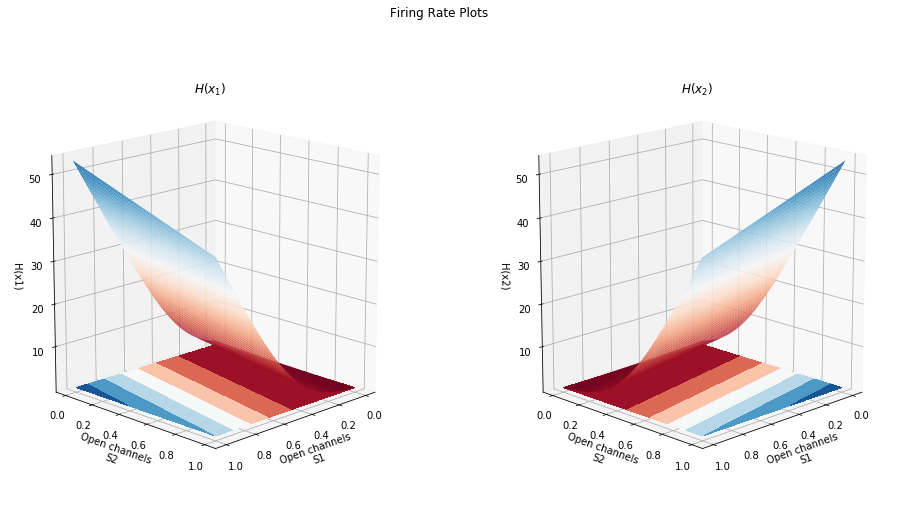

In [75]:
X1_ = model.get_xi(
    Si=S1_, Sj=S2_,
    I_i=model.J_extA*model.mu_0
)
X2_ = model.get_xi(
    Si=S2_, Sj=S1_,
    I_i=model.J_extA*model.mu_0,
    i=2
)
H1_ = model.get_H(
    xi=X1_
)
H2_ = model.get_H(
    xi=X2_
)

cmap = cm.RdBu
cmap.set_bad(color='orange')

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(121, projection='3d')
offset = H1_[~np.isnan(H1_) & ~np.isinf(H1_)].min()
ax.contourf(S1_, S2_, H1_, offset=offset, cmap=cmap)
# ax.scatter([0.1, 0.15, 0.6], [0.6, 0.15, 0.1], [0,0,0], s=4, color='black')
ax.plot_surface(S1_, S2_, H1_, cmap=cmap, vmin=-0, vmax=60)
ax.set_zlabel('H(x1)')
ax.set_xlabel('Open channels\nS1')
ax.set_ylabel('Open channels\nS2')
ax.set_title(r"$H(x_1)$")
ax.view_init(15, 45)

ax = fig.add_subplot(122, projection='3d')
offset = H2_[~np.isnan(H2_) & ~np.isinf(H2_)].min()
ax.contourf(S1_, S2_, H2_, offset=offset, cmap=cmap)
ax.plot_surface(S1_, S2_, H2_, cmap=cmap, vmin=-0, vmax=60)
ax.set_zlabel('H(x2)')
ax.set_xlabel('Open channels\nS1')
ax.set_ylabel('Open channels\nS2')
ax.set_title(r"$H(x_2)$")
ax.view_init(15, 45)

fig.suptitle("Firing Rate Plots")
plt.savefig('Firing Rate Plots')
plt.show()

In [48]:
params

{'runtime': 2,
 'dt': 0.0005,
 'save_every': 10,
 'stimulus_start': 0.1,
 'stimulus_end': 1,
 'coherence': 20,
 'threshold_S': None,
 'threshold_H': None,
 'S1_start': 0.1,
 'S2_start': 0.1,
 'n_runs': 100}

In [20]:
params['n_runs'] = 100
values = model.run_simulation(**params)

In [59]:
steps_before_stim = (values['timesteps'] < params['stimulus_start']).astype(int).sum()
mask_during_stim = (values['timesteps'] >= params['stimulus_start']) * (values['timesteps'] < params['stimulus_end'])

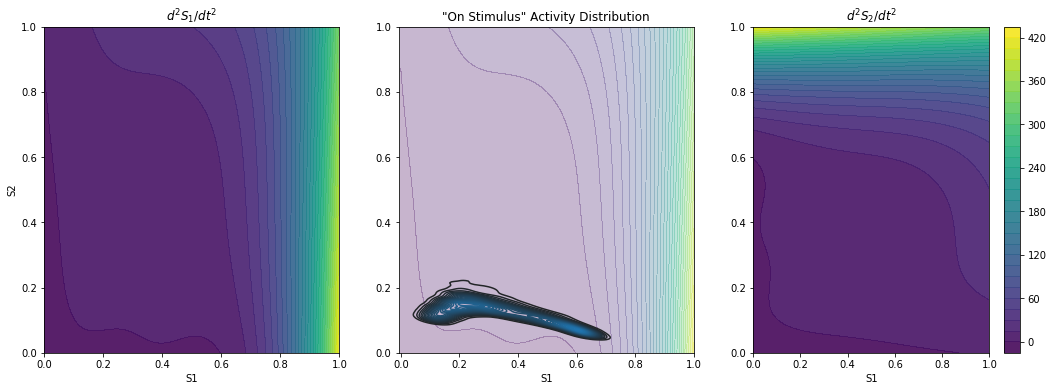

In [71]:
import seaborn as sns

figure = plt.figure(figsize=(18,6))

plt.subplot(131)
plt.contourf(S1_, S2_, d2S1dt2_, 30, alpha=0.9)  #, vmin=-10, vmax=10)
plt.ylabel('S2')
plt.xlabel('S1')
plt.title(r'$d^2 S_1 / dt^2$')
# plt.colorbar()

plt.subplot(132)
# ax = sns.kdeplot(values['S1'][::params['save_every'], :].ravel(), values['S2'][::params['save_every'], :].ravel(), n_levels=100)#, cmap="Purples_d")
ax = sns.kdeplot(
    values['S1'][mask_during_stim, :][::params['save_every'], :].ravel(),
    values['S2'][mask_during_stim, :][::params['save_every'], :].ravel(),
    n_levels=30)#, cmap="Purples_d")
ax.contourf(S1_, S2_, d2S1dt2_, 30, alpha=0.3)
ax.set_title('"On Stimulus" Activity Distribution')
plt.xlabel('S1')

plt.subplot(133)
plt.title(r'$d^2 S_2 / dt^2$')
plt.contourf(S1_, S2_, d2S2dt2_, 30, alpha=0.9)
plt.colorbar()
plt.xlabel('S1')

plt.show()

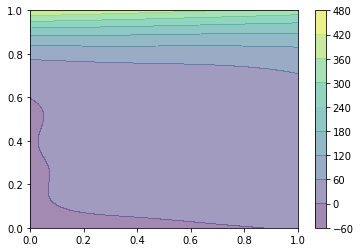

In [39]:
plt.contourf(S1_, S2_, d2S2dt2_, alpha=0.5)
plt.colorbar()

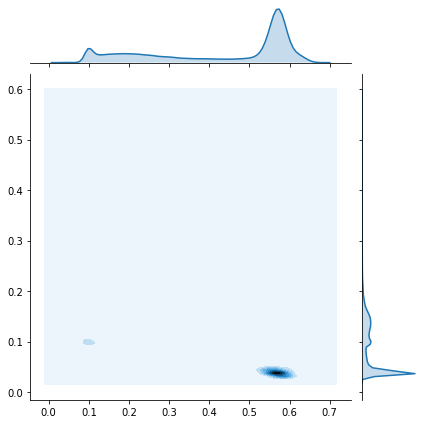

In [97]:
sns.jointplot(x=values['S1'].ravel(), y=values['S2'].ravel(), kind="kde");

## Original Formulation:

### Import Step:

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

### Params:

In [2]:
tau_S = 100  # mseconds
gamma = 0.641  # AU

a = 270  # (VnC)^-1
b = 108  # Hz
d = 154  # mseconds

J_N11 = 0.2609  # nA  i.e. 10^-9 A
J_N12 = 0.0497  # nA
J_N21 = 0.0497  # nA
J_N22 = 0.2609  # nA
I_0 = 0.3255  # nA

J_extA = 5.2e-4  # nA.Hz^-1
mu_0 = 30  # Hz
c = 0.064

tau_AMPA = 2  # mseconds
eta_1 = 1
eta_2 = 1
sigma_noise = 0.02  #nA

### Functions:

In [3]:
def x_i(S_i, S_j, J_Nii, J_Nij, I_i, I_0=I_0, I_noisei=0):
    return J_Nii*S_i + J_Nij*S_j + I_0 + I_i + I_noisei

def H(x_i, a=a, b=b, d=d):
    w = a*x_i - b
    return w / (1 - np.exp(-d*w))  # warning: overflow risk

def H_of_x1(S_1, S_2, I_1, I_0=I_0, I_noise1=0):
    x1 = x_i(S_1, S_2, J_N11, J_N12, I_1, I_0, I_noise1)
    rate = H(x1)
    return rate

def dSdt(S, H_of_x, gamma=gamma, tau_S=tau_S):
    return -S/tau_S + (1-S)*H_of_x*gamma

# def d2Sidt2(Si, Sj, J_Nii, J_Nij, gamma=gamma, tau_S=tau_S):
#     H_of_x = H_of_x1(S_1, S_2, I_1, I_0=I_0, I_noise1=0)